<a href="https://colab.research.google.com/github/vanderbilt-ml/50-shah-mlproj-traffic-accidents/blob/Assignment_4_Part_2/TrafficAccidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

#Traffic Accidents

## Background

This is dataset of traffic accidents reported from 2019 to present. The data has been retrieved using manual export and is subject to change during an investigation as more information becomes available.

## Project Description

Each record is a reported traffic accident. Check the metadata field descriptions for more detailed information.

### **Data Dictionary**

Feature	|	Description	|	Type
-------------	|	-------------	|	-------------
Accident Number	|	MNPD incident number for the crash	|	Plain Text
Date and Time	|	Date and time of the accident	|	Date & Time
Number of Motor Vehicles	|	Number of vehicles involved in the accident	|	Number
Number of Injuries	|	Number of people with injuries as a result of the accident	|	Number
Number of Fatalities	|	Number of fatalities as a result of the accident	|	Number
Property Damage	|	Indicates if there was property damage as a result of the accident	|	Checkbox
Hit and Run	|	Indicates if the accident was a hit and run	|	Checkbox
Reporting Officer	|	ID number of the officer responding to the accident	|	Plain Text
Collision Type Code	|	System code for the type of collision	|	Number
Collision Type Description	|	Full text description of the collision type	|	Plain Text
Weather Code	|	System code for the weather conditions at the time of the accident	|	Number
Weather Description	|	Full text description of the weather conditions	|	Plain Text
Illumination Code	|	System code for type of lighting at the time of the accident	|	Number
Illumination Description	|	Full text description of the lighting conditions	|	Plain Text
Harmful Code	|	System code indicating harmful objects or conditions present in the accident	|	Plain Text
Harmful Description	|	Full text description of the harmful objects or conditions	|	Plain Text
Street Address	|	Street address at which the accident occurred	|	Plain Text
City	|	City in which the accident occurred	|	Plain Text
State	|	State in which the accident occurred	|	Plain Text
ZIP	|	ZIP Code in which the accident occurred	|	Number
RPA	|	MNPD reporting zone in which the accident occurred	|	Number
Precinct	|	Assigned MNPD precinct in which the accident occurred	|	Plain Text
Latitude	|	Approximate latitude where the accident occurred	|	Number
Longitude	|	Approximate longitude where the accident occurred	|	Number
Mapped Location	|	Combined latitude and longitude for the accident for mapping purposes	|	Point

In [140]:
#tables, visualizations and define alias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#machine learnig and import modules to use with scikit learn 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load Data

Load the traffic accidents data provided using pandas and read it as a dataframe. Please note that the The repository is private so I have to use token to access .csv file.

In [141]:
penguins = pd.read_csv('https://raw.githubusercontent.com/vanderbilt-ml/50-shah-mlproj-traffic-accidents/main/Traffic_Accidents.csv?token=GHSAT0AAAAAABVNR4SXPOVZWRLJCGWC3BHGYVFM7DA')
display(penguins.head())
penguins.info()

,Accident Number,Date and Time,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Reporting Officer,Collision Type Code,Collision Type Description,...,Harmful Description,Street Address,City,State,ZIP,RPA,Precinct,Latitude,Longitude,Mapped Location
0,20220285517,6/9/2022 19:12,0,1,0,NaN,False,384443.0,11.0,Front to Rear,...,MOTOR VEHICLE IN TRANSPORT,I24E & I24 E ENT RAMP,NASHVILLE,TN,37210.0,8102.0,SOUTH,36.1363,-86.7270,POINT (-86.727 36.1363)
1,20220285427,6/9/2022 17:50,0,0,0,NaN,False,256386.0,5.0,SIDESWIPE - SAME DIRECTION,...,MOTOR VEHICLE IN TRANSPORT,WEST END AV & I440 W EXT RAMP,NASHVILLE,TN,37212.0,5905.0,MIDTOW,36.1379,-86.8206,POINT (-86.8206 36.1379)
2,20220285391,6/9/2022 17:07,0,0,0,NaN,False,4005453.0,4.0,ANGLE,...,MOTOR VEHICLE IN TRANSPORT,FRANKLIN PKE & ROBERTSON ACADEMY RD,NASHVILLE,TN,37220.0,7101.0,MIDTOW,36.0813,-86.7726,POINT (-86.7726 36.0813)
3,20220285368,6/9/2022 16:55,0,1,0,NaN,False,384443.0,4.0,ANGLE,...,MOTOR VEHICLE IN TRANSPORT;CONCRETE TRAFFIC BA...,MM 54 2 I 24,NASHVILLE,TN,37211.0,88122.0,SOUTH,36.1038,-86.7151,POINT (-86.7151 36.1038)
4,20220285352,6/9/2022 16:41,0,4,0,NaN,False,390077.0,4.0,ANGLE,...,MOTOR VEHICLE IN TRANSPORT,OLD HICKORY BLVD & I40 W EXT RAMP,HERMITAGE,TN,37076.0,9557.0,HERMIT,36.1708,-86.6016,POINT (-86.6016 36.1708)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47668 entries, 0 to 47667
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Accident Number             47668 non-null  int64  
 1   Date and Time               47668 non-null  object 
 2   Number of Motor Vehicles    47668 non-null  int64  
 3   Number of Injuries          47668 non-null  int64  
 4   Number of Fatalities        47668 non-null  int64  
 5   Property Damage             4221 non-null   object 
 6   Hit and Run                 47662 non-null  object 
 7   Reporting Officer           47667 non-null  float64
 8   Collision Type Code         47666 non-null  float64
 9   Collision Type Description  47666 non-null  object 
 10  Weather Code                42639 non-null  float64
 11  Weather Description         42639 non-null  object 
 12  Illumination Code           47575 non-null  float64
 13  Illumination Description    475

### Data Cleaning
Detect and Remove Missing values

After exploring and observing the data, there are a few columns with the coded value for which the description is already available. I am removing data values out of the dataframe.

The columns are specified below:

**Date and Time**, **Reporting Officer**, **Collision Type Code**, **Weather Code**, **Illumination Code**, **Harmful Code**, **RPA**

In [142]:
penguins = penguins.drop(columns=['Reporting Officer', 'Collision Type Code', 'Weather Code', 'Illumination Code', 'Harmful Code', 'RPA'])
print(penguins.columns)

Index(['Accident Number', 'Date and Time', 'Number of Motor Vehicles',
       'Number of Injuries', 'Number of Fatalities', 'Property Damage',
       'Hit and Run', 'Collision Type Description', 'Weather Description',
       'Illumination Description', 'Harmful Description', 'Street Address',
       'City', 'State', 'ZIP', 'Precinct', 'Latitude', 'Longitude',
       'Mapped Location'],
      dtype='object')


In [143]:
penguins.isna().sum()

Accident Number                   0
Date and Time                     0
Number of Motor Vehicles          0
Number of Injuries                0
Number of Fatalities              0
Property Damage               43447
Hit and Run                       6
Collision Type Description        2
Weather Description            5029
Illumination Description         93
Harmful Description             670
Street Address                    0
City                              0
State                             0
ZIP                              24
Precinct                         20
Latitude                        314
Longitude                       314
Mapped Location                 314
dtype: int64

In [145]:
penguins = penguins.dropna()

In [146]:
penguins.isnull()

,Accident Number,Date and Time,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Collision Type Description,Weather Description,Illumination Description,Harmful Description,Street Address,City,State,ZIP,Precinct,Latitude,Longitude,Mapped Location
59,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
76,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
81,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
85,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
105,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47620,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
47645,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
47649,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
47652,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Feature Engineering

There are many feature engineering techniques including e.g. Imputation, Handling Outliers, Binning, Log Transform, One-Hot Encoding, Grouping Operations, Feature Split, Scaling etc. 

We will be applying lesson learned from various assignments lets create some statistics on the  data attached here. Also create the test and train set, pipeline and check/learn the outcome of the data.

In [147]:
penguins.shape
penguins.head()

,Accident Number,Date and Time,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Property Damage,Hit and Run,Collision Type Description,Weather Description,Illumination Description,Harmful Description,Street Address,City,State,ZIP,Precinct,Latitude,Longitude,Mapped Location
59,20220283101,6/8/2022 12:50,0,1,0,True,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DAYLIGHT,TREE,OLD FRANKLIN RD & PRESTON RD,ANTIOCH,TN,37013.0,SOUTH,36.0316,-86.6616,POINT (-86.6616 36.0316)
76,20220282330,6/8/2022 3:44,0,1,0,True,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,RAIN,DARK - NOT LIGHTED,BOULDER;FENCE;OTHER FIXED OBJECTS;Ran Off Road...,NASHBORO BLVD & FAIRWAY POINTE PVTDR,NASHVILLE,TN,37217.0,HERMIT,36.0895,-86.6293,POINT (-86.6293 36.0895)
81,20220282009,6/7/2022 23:19,0,0,0,True,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLOUDY,DARK - LIGHTED,"UTILITY POLE;OTHER POST, POLE, SUPP.",DR D B TODD JR BLVD & OSAGE ST,NASHVILLE,TN,37208.0,NORTH,36.1771,-86.8098,POINT (-86.8098 36.1771)
85,20220281702,6/7/2022 20:31,0,0,0,True,False,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLOUDY,DARK - NOT LIGHTED,DITCH;FENCE,RIVER ROAD PKE & RIVER ROAD PKE PVTDR,NASHVILLE,TN,37209.0,WEST,36.2021,-86.9796,POINT (-86.9796 36.2021)
105,20220281286,6/7/2022 14:58,0,0,0,True,False,Front to Rear,RAIN,DAYLIGHT,MOTOR VEHICLE IN TRANSPORT;GUARDRAIL FACE,MM 193 0 I 40,NASHVILLE,TN,37221.0,WEST,36.0771,-87.0122,POINT (-87.0122 36.0771)


**Total Number of accidents based on Collission Type**

In [148]:
penguins["Collision Type Description"].unique()

array(['NOT COLLISION W/MOTOR VEHICLE-TRANSPORT', 'Front to Rear',
       'ANGLE', 'UNKNOWN', 'HEAD-ON', 'SIDESWIPE - OPPOSITE DIRECTION',
       'SIDESWIPE - SAME DIRECTION', 'OTHER', 'Rear to Side',
       'REAR-TO-REAR'], dtype=object)

In [150]:
collision_types = penguins["Collision Type Description"].unique()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


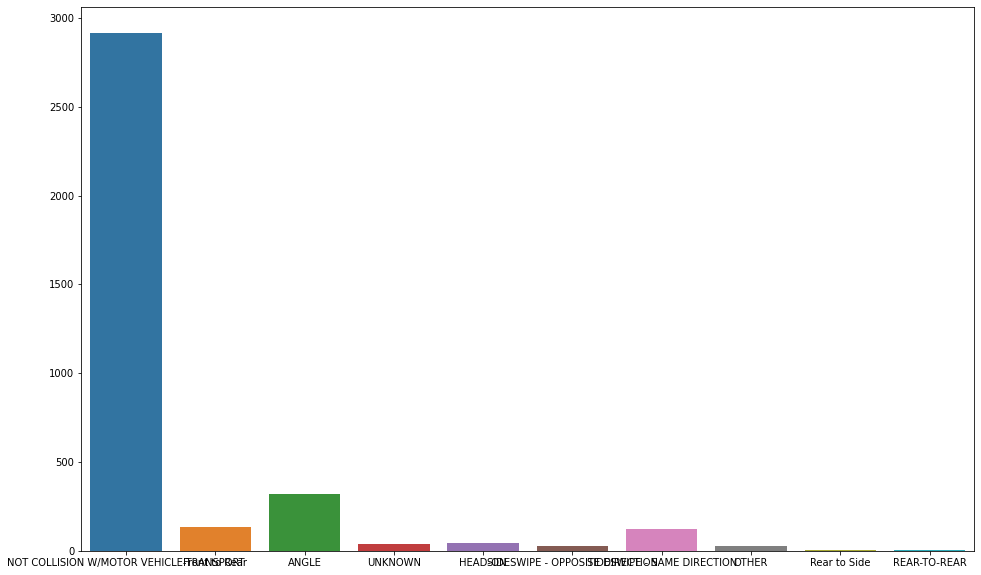

In [151]:
counts_by_collision_type=[]
for i in penguins["Collision Type Description"].unique(): counts_by_collision_type.append(penguins[penguins['Collision Type Description']==i].count()['Accident Number'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(collision_types, counts_by_collision_type)

**Total Number of accidents based on Weather Condition**

In [152]:
penguins["Weather Description"].unique()

array(['CLEAR', 'RAIN', 'CLOUDY', 'UNKNOWN', 'FOG', 'SNOW', 'SLEET, HAIL',
       'BLOWING SNOW', 'OTHER (NARRATIVE)', 'SMOG, SMOKE',
       'SEVERE CROSSWIND'], dtype=object)

In [153]:
weather_conditions = penguins["Weather Description"].unique()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


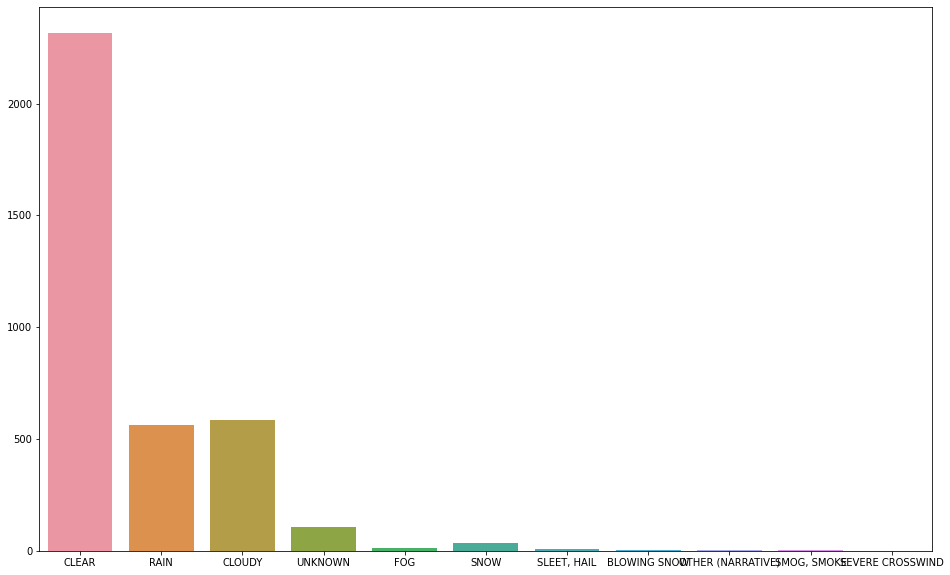

In [154]:
counts_by_weather_condition=[]
for i in penguins["Weather Description"].unique(): counts_by_weather_condition.append(penguins[penguins['Weather Description']==i].count()['Accident Number'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(weather_conditions, counts_by_weather_condition)

**Total Number of accidents by Day Of Week**

In [181]:
accident_DOW = pd.to_datetime(penguins["Date and Time"]).dt.day_name().unique()

In [182]:
print(accident_DOW)

['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


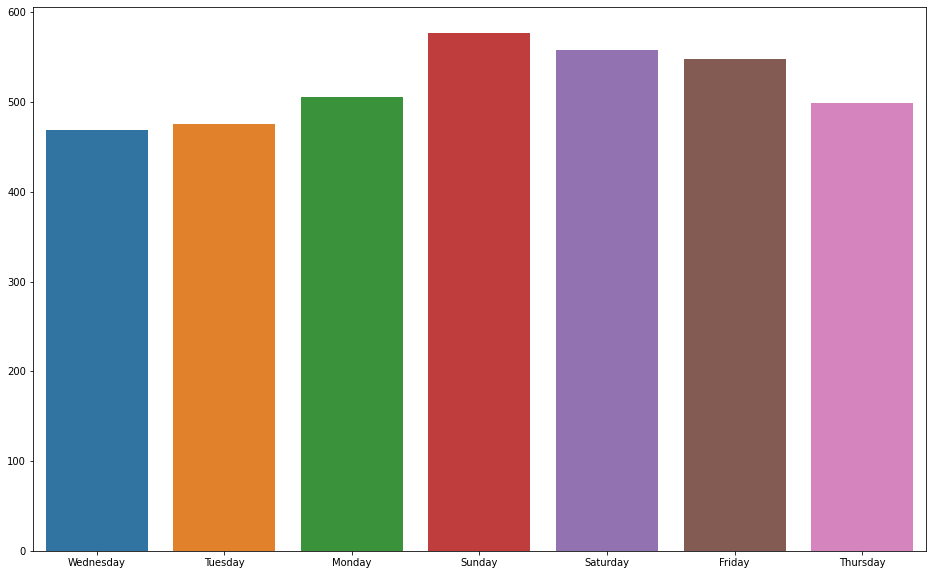

In [187]:
counts_by_DOW=[]
for i in pd.to_datetime(penguins["Date and Time"]).dt.day_name().unique(): counts_by_DOW.append(penguins[pd.to_datetime(penguins["Date and Time"]).dt.day_name()==i].count()['Accident Number'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(accident_DOW, counts_by_DOW)

In [200]:
penguins = penguins.drop(columns=['Date and Time'])
print(penguins.columns)

KeyError: ignored

In [201]:
penguins.isna().sum()

Accident Number               0
Number of Motor Vehicles      0
Number of Injuries            0
Number of Fatalities          0
Property Damage               0
Hit and Run                   0
Collision Type Description    0
Weather Description           0
Illumination Description      0
Harmful Description           0
Street Address                0
City                          0
State                         0
ZIP                           0
Precinct                      0
Latitude                      0
Longitude                     0
Mapped Location               0
dtype: int64

**One-Hot Encoding**

I would like to intruduce One-Hot Encoding here by focusing on **Hit and Run** column.

The **Hit and Run** column will be replaced with three new columns: HitAndRun_TRUE, and HitAndRun_FALSE.

In [202]:
penguins_one_hot_encoded = pd.get_dummies(penguins, columns=["Hit and Run"], prefix = "HitAndRun")
print(penguins_one_hot_encoded[["HitAndRun_False", "HitAndRun_True"]].head)
print(penguins_one_hot_encoded.columns)
print(penguins_one_hot_encoded.shape)

<bound method NDFrame.head of        HitAndRun_False  HitAndRun_True
59                   1               0
76                   1               0
81                   1               0
85                   1               0
105                  1               0
...                ...             ...
47620                1               0
47645                1               0
47649                0               1
47652                1               0
47667                0               1

[3633 rows x 2 columns]>
Index(['Accident Number', 'Number of Motor Vehicles', 'Number of Injuries',
       'Number of Fatalities', 'Property Damage', 'Collision Type Description',
       'Weather Description', 'Illumination Description',
       'Harmful Description', 'Street Address', 'City', 'State', 'ZIP',
       'Precinct', 'Latitude', 'Longitude', 'Mapped Location',
       'HitAndRun_False', 'HitAndRun_True'],
      dtype='object')
(3633, 19)


**Build Test and Train Set**

In [203]:
class_column = 'Property Damage'
random_seed = 2435

X_train, X_test, y_train, y_test = train_test_split(penguins_one_hot_encoded.drop(columns=class_column), penguins_one_hot_encoded[class_column],
                                                   test_size=0.25, random_state=random_seed, stratify=penguins_one_hot_encoded[class_column])

In [204]:
# X Train
print('On X train: ')
print('X train dimensions: ', X_train.shape)
display(X_train.head())

# X test
print('\nOn X test: ')
print('X test dimensions: ', X_test.shape)
display(X_test.head())

On X train: 
X train dimensions:  (2724, 18)


,Accident Number,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Collision Type Description,Weather Description,Illumination Description,Harmful Description,Street Address,City,State,ZIP,Precinct,Latitude,Longitude,Mapped Location,HitAndRun_False,HitAndRun_True
28371,20200730956,1,1,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DARK - LIGHTED,UTILITY POLE,936 E TRINITY LN,NASHVILLE,TN,37216.0,EAST,36.2045,-86.7481,POINT (-86.7481 36.2045),1,0
41392,20200174032,1,0,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLOUDY,DAYLIGHT,UTILITY POLE,18TH AVE N & CHURCH ST,NASHVILLE,TN,37203.0,MIDTOW,36.1550,-86.7975,POINT (-86.7975 36.155),1,0
14009,20210474124,1,0,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DARK - LIGHTED,BUILDING,CAMPBELL RD & DICKERSON PKES,GOODLETTSVILLE,TN,37072.0,MADISO,36.2924,-86.7337,POINT (-86.7337 36.2924),0,1
2821,20220179301,1,0,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DAYLIGHT,OTHER OBJECT (NOT FIXED),OLD HICKORY BLVD & BELLEVUE VALLEY PLAZA,NASHVILLE,TN,37221.0,WEST,36.0734,-86.9207,POINT (-86.9207 36.0734),1,0
5151,20220089169,0,0,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DARK - LIGHTED,BUILDING,200 2ND AVS,NASHVILLE,TN,37201.0,CENTRA,36.1593,-86.7735,POINT (-86.7735 36.1593),1,0



On X test: 
X test dimensions:  (909, 18)


,Accident Number,Number of Motor Vehicles,Number of Injuries,Number of Fatalities,Collision Type Description,Weather Description,Illumination Description,Harmful Description,Street Address,City,State,ZIP,Precinct,Latitude,Longitude,Mapped Location,HitAndRun_False,HitAndRun_True
9354,20210612749,0,1,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DAYLIGHT,Ran Off Road-Right,PASQUO RD & HIGHWAY 100,NASHVILLE,TN,37221.0,WEST,36.0353,-86.9682,POINT (-86.9682 36.0353),1,0
28574,20200722907,1,1,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DARK - NOT LIGHTED,UTILITY POLE;WALL,US HWY 31 & 9TH AVE N,NASHVILLE,TN,37203.0,CENTRA,36.1611,-86.7835,POINT (-86.7835 36.1611),1,0
18408,20210326029,2,1,0,ANGLE,CLEAR,DAYLIGHT,MOTOR VEHICLE IN TRANSPORT,ARTHUR AV & CHEATHAM PL,NASHVILLE,TN,37208.0,NORTH,36.1753,-86.7983,POINT (-86.7983 36.1753),1,0
5880,20220066025,0,0,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DAYLIGHT,FENCE,CODY HILL RD & SCOUT DR,NASHVILLE,TN,37211.0,MIDTOW,36.0259,-86.7214,POINT (-86.7214 36.0259),1,0
20663,20210242986,1,0,0,NOT COLLISION W/MOTOR VEHICLE-TRANSPORT,CLEAR,DARK - LIGHTED,FENCE,FATHERLAND ST & PROSPECT ST,NASHVILLE,TN,37206.0,EAST,36.1733,-86.7544,POINT (-86.7544 36.1733),0,1


In [205]:
# Y Train
print('On y train: ')
print('y train dimensions: ', y_train.shape)
display(y_train.head())

# Y test
print('\nOn y test: ')
print('y test dimensions: ', y_test.shape)
display(y_test.head())

On y train: 
y train dimensions:  (2724,)


28371    True
41392    True
14009    True
2821     True
5151     True
Name: Property Damage, dtype: object


On y test: 
y test dimensions:  (909,)


9354     True
28574    True
18408    True
5880     True
20663    True
Name: Property Damage, dtype: object

### Training pipeline

Establish the training pipeline for model and repeat several times as needed The pipeline can also change depending on the data types of the columns in the dataset.

In [206]:
#individual pipelines for differing datatypes
cat_pipeline = Pipeline(steps=[('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                               ('onehot_cat', OneHotEncoder(drop='if_binary'))])
num_pipeline = Pipeline(steps=[('impute_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
                               ('scale_num', StandardScaler())])

In [208]:
#establish preprocessing pipeline by columns
preproc = ColumnTransformer([('cat_pipe', cat_pipeline, make_column_selector(dtype_include=object)),
                             ('num_pipe', num_pipeline, make_column_selector(dtype_include=np.number))],
                             remainder='passthrough')

In [209]:
#generate the whole modeling pipeline with preprocessing
pipe = Pipeline(steps=[('preproc', preproc),
                       ('mdl', LogisticRegression(penalty='elasticnet', solver='saga', tol=0.01))])

#visualization for steps
with config_context(display='diagram'): display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_cat',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa5fc37910>),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('scale_num',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ffa5fc37e10>)])),
                ('mdl',
                 LogisticRegression(penalty='elasticnet', solver='saga',
                                    tol=0.01))])

## Performance metrics

If successfull, the project will idenfiy following features:

*   Break down number of accidents by type of collision type and weather conditions. 
*   Accident frequency by day of week

By reviewing the metrics below one can also identify, when do accidents occur most frequently.